In [56]:
# Read Data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
ticker_names = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", \
           "GOOGL", "META", "TSM", "LLY", "AVGO", \
            "NVO", "TSLA", "JPM", "V", "WMT", \
                "UNH", "MA", "XOM", "ASML", "JNJ"]
dfs = []
X = []
Y = []

time_steps = 7

for name in ticker_names:  
    df = pd.read_csv(f'../DATA/Cleaned Datas/cleaned_{name}_prices.csv')
    df = df.drop(columns=['Date'])
    df = df.drop(columns=['Volume'])
    scaler_of_df = MinMaxScaler(feature_range=(0,1))
    df_scaled = scaler_of_df.fit_transform(df)
    dfs.append(df_scaled)

    
    open = np.array(df_scaled[:, 0])
    high = np.array(df_scaled[:, 1])
    low = np.array(df_scaled[:, 2])
    close = np.array(df_scaled[:, 3])

    X_name = []
    Y_name = []
    

    for i in range(len(open)-time_steps-1):
        X_i = np.vstack((open[i:i+time_steps], high[i:i+time_steps], low[i:i+time_steps])).T
        Y_i = close[i+time_steps]
        X_name.append(X_i)
        Y_name.append(Y_i)

    X_name = np.array(X_name)
    Y_name = np.array(Y_name)

    X.append(X_name)
    Y.append(Y_name)

X = np.array(X) # 3d arr: num_ticker * num_sample * num_features
Y = np.array(Y) # 2d arr: num_ticker * num_sample

X_trains = [] # 3d arr: ticker * sample * features
Y_trains = [] # 2d arr: ticker * sample
X_cvs = [] # 3d arr: ticker * sample * features
Y_cvs = [] # 2d arr: ticker * sample
X_tests = [] # 3d arr: ticker * sample * features
Y_tests = [] # 2d arr: ticker * sample

training_sizes = []
cv_sizes = []
test_sizes = []

for ticker in X:
    train_size = int(len(ticker) * 0.6)
    cv_size = int(len(ticker) * 0.2)
    test_size = len(ticker) - train_size - cv_size

    training_sizes.append(train_size)
    cv_sizes.append(cv_size)
    test_sizes.append(test_size)

    X_train = ticker[:train_size]
    X_cv = ticker[train_size:train_size+cv_size]
    X_test = ticker[train_size+cv_size:]

    X_trains.append(X_train)
    X_cvs.append(X_cv)
    X_tests.append(X_test)


for ticker in Y:
    train_size = int(len(ticker) * 0.6)
    cv_size = int(len(ticker) * 0.2)

    Y_train = ticker[:train_size]
    Y_cv = ticker[train_size:train_size+cv_size]
    Y_test = ticker[train_size+cv_size:]

    Y_trains.append(Y_train)
    Y_cvs.append(Y_cv)
    Y_tests.append(Y_test)


X_trains = np.array(X_trains) # 3d arr: ticker * sample * features
Y_trains = np.array(Y_trains) # 2d arr: ticker * sample
X_cvs = np.array(X_cvs) # 3d arr: ticker * sample * features
Y_cvs = np.array(Y_cvs) # 2d arr: ticker * sample
X_tests = np.array(X_tests) # 3d arr: ticker * sample * features
Y_tests = np.array(Y_tests) # 2d arr: ticker * sample


/var/folders/c1/t6c91th93rg_t8cmmzfjwp840000gn/T/ipykernel_16339/1596732867.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X) # 3d arr: num_ticker * num_sample * num_features
/var/folders/c1/t6c91th93rg_t8cmmzfjwp840000gn/T/ipykernel_16339/1596732867.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y) # 2d arr: num_ticker * num_sample
/var/folders/c1/t6c91th93rg_t8cmmzfjwp840000gn/T/ipykernel_16339/1596732867.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.losses import mse, mae
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping



time_steps = 7 # a week of steps
input_dim = 3 # OHL

histories = []

for i in range(len(ticker_names)):
    x_t = X_trains[i]
    y_t = Y_trains[i]
    x_cv = X_cvs[i]
    y_cv = Y_cvs[i]


    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss',  # Or 'val_accuracy' depending on what you want to monitor
                                min_delta=0.001,  # Minimum change to qualify as an improvement
                                patience= 15,  # How many epochs to wait before stopping
                                restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity
    
    model = Sequential([   
        LSTM(units= 256, return_sequences=True, input_shape=(time_steps, input_dim)),
        LSTM(units= 128, return_sequences=False),
        Dense(units= 64, activation='relu'),
        Dense(units= 1, activation='linear'),
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    history = model.fit(x_t, y_t, validation_data=(x_cv, y_cv) , epochs=100, batch_size=64, callbacks=[early_stopping])
    model.save(f'{ticker_names[i]}.h5')
    histories.append(history)


Epoch 1/100


2024-03-14 19:24:17.906082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:24:17.906877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:24:17.907318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

89/90 [============================>.] - ETA: 0s - loss: 0.0019

2024-03-14 19:24:20.370352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:24:20.371048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:24:20.371576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

90/90 [==============================] - 3s 18ms/step - loss: 0.0019 - val_loss: 1.0376e-05
Epoch 2/100
90/90 [==============================] - 1s 15ms/step - loss: 5.3850e-06 - val_loss: 6.2205e-06
Epoch 3/100
90/90 [==============================] - 1s 16ms/step - loss: 5.7073e-06 - val_loss: 8.5990e-06
Epoch 4/100
90/90 [==============================] - 1s 16ms/step - loss: 6.2173e-06 - val_loss: 7.8387e-06
Epoch 5/100
90/90 [==============================] - 1s 16ms/step - loss: 6.8580e-06 - val_loss: 7.5066e-06
Epoch 6/100
90/90 [==============================] - 1s 16ms/step - loss: 6.9447e-06 - val_loss: 5.7610e-06
Epoch 7/100
90/90 [==============================] - 1s 16ms/step - loss: 6.7106e-06 - val_loss: 6.9734e-06
Epoch 8/100
90/90 [==============================] - 1s 16ms/step - loss: 5.6707e-06 - val_loss: 1.4861e-05
Epoch 9/100
90/90 [==============================] - 1s 16ms/step - loss: 5.6602e-06 - val_loss: 7.1830e-06
Epoch 10/100
90/90 [========================

2024-03-14 19:24:42.443702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:24:42.444246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:24:42.444913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

103/103 [==============================] - ETA: 0s - loss: 3.2292e-04

2024-03-14 19:24:45.169216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:24:45.169934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:24:45.170340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

103/103 [==============================] - 3s 19ms/step - loss: 3.2292e-04 - val_loss: 0.0020
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 3.3986e-07 - val_loss: 3.5655e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 1.0519e-07 - val_loss: 3.6245e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 3.8522e-07 - val_loss: 3.8123e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 6.4488e-07 - val_loss: 4.0146e-04
Epoch 6/100
103/103 [==============================] - 2s 16ms/step - loss: 2.7459e-07 - val_loss: 5.3548e-04
Epoch 7/100
103/103 [==============================] - 2s 17ms/step - loss: 2.9112e-07 - val_loss: 5.7476e-04
Epoch 8/100
103/103 [==============================] - 2s 16ms/step - loss: 1.7068e-07 - val_loss: 7.5935e-04
Epoch 9/100
103/103 [==============================] - 2s 17ms/step - loss: 2.2510e-07 - val_loss: 7.9077e-04
Epoch 10/100
103/103 [====

2024-03-14 19:25:12.562415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:25:12.562949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:25:12.563650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

59/60 [============================>.] - ETA: 0s - loss: 3.5631e-04

2024-03-14 19:25:14.656861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:25:14.657550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:25:14.657945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 2s 21ms/step - loss: 3.5509e-04 - val_loss: 0.0011
Epoch 2/100
60/60 [==============================] - 1s 16ms/step - loss: 3.6254e-06 - val_loss: 9.2986e-04
Epoch 3/100
60/60 [==============================] - 1s 16ms/step - loss: 3.5268e-06 - val_loss: 6.9531e-04
Epoch 4/100
60/60 [==============================] - 1s 16ms/step - loss: 2.0284e-06 - val_loss: 4.2509e-04
Epoch 5/100
60/60 [==============================] - 1s 18ms/step - loss: 7.1830e-07 - val_loss: 1.4745e-04
Epoch 6/100
60/60 [==============================] - 1s 17ms/step - loss: 6.5231e-07 - val_loss: 1.9683e-04
Epoch 7/100
60/60 [==============================] - 1s 16ms/step - loss: 4.1588e-07 - val_loss: 2.0614e-04
Epoch 8/100
60/60 [==============================] - 1s 17ms/step - loss: 3.7751e-07 - val_loss: 2.7712e-04
Epoch 9/100
60/60 [==============================] - 1s 18ms/step - loss: 2.6114e-07 - val_loss: 2.7121e-04
Epoch 10/100
60/60 [========================

2024-03-14 19:25:30.920110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:25:30.920647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:25:30.921366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

64/64 [==============================] - ETA: 0s - loss: 0.0015

2024-03-14 19:25:33.116961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:25:33.117870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:25:33.118354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

64/64 [==============================] - 2s 20ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/100
64/64 [==============================] - 1s 17ms/step - loss: 2.7571e-06 - val_loss: 5.5334e-04
Epoch 3/100
64/64 [==============================] - 1s 16ms/step - loss: 2.9228e-06 - val_loss: 6.9560e-04
Epoch 4/100
64/64 [==============================] - 1s 16ms/step - loss: 4.6752e-06 - val_loss: 3.8139e-04
Epoch 5/100
64/64 [==============================] - 1s 17ms/step - loss: 3.2915e-06 - val_loss: 4.5972e-04
Epoch 6/100
64/64 [==============================] - 1s 17ms/step - loss: 3.8449e-06 - val_loss: 8.1763e-04
Epoch 7/100
64/64 [==============================] - 1s 16ms/step - loss: 6.4961e-06 - val_loss: 8.8074e-04
Epoch 8/100
64/64 [==============================] - 1s 16ms/step - loss: 2.8528e-06 - val_loss: 6.7967e-04
Epoch 9/100
64/64 [==============================] - 1s 16ms/step - loss: 3.7950e-06 - val_loss: 7.9658e-04
Epoch 10/100
64/64 [============================

2024-03-14 19:25:49.230042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:25:49.230721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:25:49.231095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/47 [===========================>..] - ETA: 0s - loss: 0.0037

2024-03-14 19:25:51.102414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:25:51.103093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:25:51.103652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 2s 20ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 2/100
47/47 [==============================] - 1s 16ms/step - loss: 2.5662e-05 - val_loss: 9.2026e-04
Epoch 3/100
47/47 [==============================] - 1s 16ms/step - loss: 1.7644e-05 - val_loss: 6.8301e-04
Epoch 4/100
47/47 [==============================] - 1s 17ms/step - loss: 1.5843e-05 - val_loss: 2.8228e-04
Epoch 5/100
47/47 [==============================] - 1s 17ms/step - loss: 1.7073e-05 - val_loss: 1.8965e-04
Epoch 6/100
47/47 [==============================] - 1s 17ms/step - loss: 2.0359e-05 - val_loss: 4.3338e-04
Epoch 7/100
47/47 [==============================] - 1s 17ms/step - loss: 2.3140e-05 - val_loss: 7.0604e-04
Epoch 8/100
47/47 [==============================] - 1s 17ms/step - loss: 1.8969e-05 - val_loss: 2.4764e-04
Epoch 9/100
47/47 [==============================] - 1s 16ms/step - loss: 1.9791e-05 - val_loss: 0.0012
Epoch 10/100
47/47 [==============================] 

2024-03-14 19:26:03.361233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:03.361794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:03.362430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/47 [===========================>..] - ETA: 0s - loss: 0.0063

2024-03-14 19:26:05.266404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:05.267033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:05.267399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 2s 21ms/step - loss: 0.0060 - val_loss: 6.9029e-04
Epoch 2/100
47/47 [==============================] - 1s 16ms/step - loss: 3.6209e-05 - val_loss: 0.0013
Epoch 3/100
47/47 [==============================] - 1s 17ms/step - loss: 2.9959e-05 - val_loss: 7.4928e-04
Epoch 4/100
47/47 [==============================] - 1s 18ms/step - loss: 1.8438e-05 - val_loss: 7.8727e-04
Epoch 5/100
47/47 [==============================] - 1s 18ms/step - loss: 3.2500e-05 - val_loss: 1.5927e-04
Epoch 6/100
47/47 [==============================] - 1s 18ms/step - loss: 2.3425e-05 - val_loss: 8.0503e-04
Epoch 7/100
47/47 [==============================] - 1s 17ms/step - loss: 2.2721e-05 - val_loss: 4.6509e-04
Epoch 8/100
47/47 [==============================] - 1s 18ms/step - loss: 3.4010e-05 - val_loss: 5.6830e-04
Epoch 9/100
47/47 [==============================] - 1s 18ms/step - loss: 1.6589e-05 - val_loss: 4.8882e-04
Epoch 10/100
47/47 [============================

2024-03-14 19:26:17.860239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:17.860985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:17.861495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - ETA: 0s - loss: 0.1216

2024-03-14 19:26:19.798898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:19.799573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:19.800194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 2s 26ms/step - loss: 0.1216 - val_loss: 0.0112
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 1.6829e-04 - val_loss: 0.0012
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 8.1776e-05 - val_loss: 6.8121e-04
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 7.3760e-05 - val_loss: 2.7887e-04
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 8.9628e-05 - val_loss: 3.3337e-04
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 7.7128e-05 - val_loss: 8.0022e-04
Epoch 7/100
28/28 [==============================] - 0s 18ms/step - loss: 1.2179e-04 - val_loss: 7.5889e-04
Epoch 8/100
28/28 [==============================] - 1s 19ms/step - loss: 1.6781e-04 - val_loss: 2.7851e-04
Epoch 9/100
28/28 [==============================] - 1s 19ms/step - loss: 5.4253e-05 - val_loss: 3.0165e-04
Epoch 10/100
28/28 [==============================] 

2024-03-14 19:26:28.566707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:28.567334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:28.567935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/63 [===========================>..] - ETA: 0s - loss: 8.1728e-04

2024-03-14 19:26:30.811210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:30.811948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:30.812421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 2s 22ms/step - loss: 7.8945e-04 - val_loss: 4.6441e-04
Epoch 2/100
63/63 [==============================] - 1s 18ms/step - loss: 3.3454e-05 - val_loss: 9.6226e-04
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 2.2089e-05 - val_loss: 4.2671e-04
Epoch 4/100
63/63 [==============================] - 1s 18ms/step - loss: 2.1286e-05 - val_loss: 9.6015e-04
Epoch 5/100
63/63 [==============================] - 1s 19ms/step - loss: 2.6597e-05 - val_loss: 6.0778e-04
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 1.9932e-05 - val_loss: 4.0651e-04
Epoch 7/100
63/63 [==============================] - 1s 18ms/step - loss: 2.3232e-05 - val_loss: 3.8620e-04
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 2.2068e-05 - val_loss: 5.6482e-04
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 1.8832e-05 - val_loss: 8.0082e-04
Epoch 10/100
63/63 [====================

2024-03-14 19:26:48.450038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:48.450823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:48.451270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

120/123 [============================>.] - ETA: 0s - loss: 0.0678

2024-03-14 19:26:51.605793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:26:51.606488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:26:51.606913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

123/123 [==============================] - 3s 19ms/step - loss: 0.0665 - val_loss: 8.5996e-06
Epoch 2/100
123/123 [==============================] - 2s 18ms/step - loss: 1.0837e-05 - val_loss: 2.4455e-05
Epoch 3/100
123/123 [==============================] - 2s 18ms/step - loss: 9.4155e-06 - val_loss: 1.1941e-05
Epoch 4/100
123/123 [==============================] - 2s 18ms/step - loss: 8.4355e-06 - val_loss: 1.8449e-05
Epoch 5/100
123/123 [==============================] - 2s 18ms/step - loss: 7.5898e-06 - val_loss: 7.3833e-06
Epoch 6/100
123/123 [==============================] - 2s 18ms/step - loss: 7.5946e-06 - val_loss: 2.9124e-05
Epoch 7/100
123/123 [==============================] - 2s 18ms/step - loss: 8.3002e-06 - val_loss: 4.3194e-06
Epoch 8/100
123/123 [==============================] - 2s 18ms/step - loss: 8.0486e-06 - val_loss: 4.5620e-06
Epoch 9/100
123/123 [==============================] - 2s 18ms/step - loss: 7.2768e-06 - val_loss: 4.2188e-06
Epoch 10/100
123/123 [====

2024-03-14 19:27:25.231512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:27:25.232299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:27:25.232759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/35 [==============================] - ETA: 0s - loss: 0.0085

2024-03-14 19:27:26.973354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:27:26.974033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:27:26.974478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/35 [==============================] - 2s 24ms/step - loss: 0.0085 - val_loss: 0.0016
Epoch 2/100
35/35 [==============================] - 1s 18ms/step - loss: 9.5707e-05 - val_loss: 2.9799e-04
Epoch 3/100
35/35 [==============================] - 1s 18ms/step - loss: 1.3104e-05 - val_loss: 1.4332e-04
Epoch 4/100
35/35 [==============================] - 1s 18ms/step - loss: 9.4358e-06 - val_loss: 1.1882e-04
Epoch 5/100
35/35 [==============================] - 1s 18ms/step - loss: 1.1628e-05 - val_loss: 8.9408e-05
Epoch 6/100
35/35 [==============================] - 1s 17ms/step - loss: 1.6736e-05 - val_loss: 1.2096e-04
Epoch 7/100
35/35 [==============================] - 1s 17ms/step - loss: 1.2345e-05 - val_loss: 1.1168e-04
Epoch 8/100
35/35 [==============================] - 1s 17ms/step - loss: 1.3917e-05 - val_loss: 1.2196e-04
Epoch 9/100
35/35 [==============================] - 1s 17ms/step - loss: 1.5480e-05 - val_loss: 1.0767e-04
Epoch 10/100
35/35 [============================

2024-03-14 19:27:37.092166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:27:37.092776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:27:37.093141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

102/102 [==============================] - ETA: 0s - loss: 5.1491e-04

2024-03-14 19:27:39.934336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:27:39.934845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:27:39.935386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

102/102 [==============================] - 3s 24ms/step - loss: 5.1491e-04 - val_loss: 4.3144e-04
Epoch 2/100
102/102 [==============================] - 2s 18ms/step - loss: 5.7527e-07 - val_loss: 4.9754e-04
Epoch 3/100
102/102 [==============================] - 2s 18ms/step - loss: 1.5068e-07 - val_loss: 4.8667e-04
Epoch 4/100
102/102 [==============================] - 2s 19ms/step - loss: 1.8911e-07 - val_loss: 5.1358e-04
Epoch 5/100
102/102 [==============================] - 2s 18ms/step - loss: 1.6616e-07 - val_loss: 5.3897e-04
Epoch 6/100
102/102 [==============================] - 2s 19ms/step - loss: 4.1236e-07 - val_loss: 6.2598e-04
Epoch 7/100
102/102 [==============================] - 2s 19ms/step - loss: 6.4074e-07 - val_loss: 8.2077e-04
Epoch 8/100
102/102 [==============================] - 2s 19ms/step - loss: 4.4805e-07 - val_loss: 0.0010
Epoch 9/100
102/102 [==============================] - 2s 18ms/step - loss: 3.5475e-07 - val_loss: 0.0013
Epoch 10/100
102/102 [========

2024-03-14 19:28:08.823665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:28:08.824432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:28:08.824972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - ETA: 0s - loss: 0.0039

2024-03-14 19:28:10.553066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:28:10.553572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:28:10.554072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 2s 24ms/step - loss: 0.0039 - val_loss: 0.0673
Epoch 2/100
33/33 [==============================] - 1s 17ms/step - loss: 3.4579e-04 - val_loss: 0.0661
Epoch 3/100
33/33 [==============================] - 1s 17ms/step - loss: 2.4935e-04 - val_loss: 0.0508
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 4.3207e-05 - val_loss: 0.0367
Epoch 5/100
33/33 [==============================] - 1s 21ms/step - loss: 6.9401e-06 - val_loss: 0.0394
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 5.5534e-06 - val_loss: 0.0390
Epoch 7/100
33/33 [==============================] - 1s 18ms/step - loss: 5.1360e-06 - val_loss: 0.0388
Epoch 8/100
33/33 [==============================] - 1s 20ms/step - loss: 4.6315e-06 - val_loss: 0.0385
Epoch 9/100
33/33 [==============================] - 1s 19ms/step - loss: 4.7324e-06 - val_loss: 0.0382
Epoch 10/100
33/33 [==============================] - 1s 19ms/step - loss: 4.466

2024-03-14 19:28:30.362699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:28:30.363365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:28:30.363771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

102/104 [============================>.] - ETA: 0s - loss: 0.0025

2024-03-14 19:28:33.450537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:28:33.451272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:28:33.451965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

104/104 [==============================] - 3s 21ms/step - loss: 0.0025 - val_loss: 9.6571e-05
Epoch 2/100
104/104 [==============================] - 2s 19ms/step - loss: 5.1032e-05 - val_loss: 9.5947e-05
Epoch 3/100
104/104 [==============================] - 2s 19ms/step - loss: 4.4728e-05 - val_loss: 1.0327e-04
Epoch 4/100
104/104 [==============================] - 2s 18ms/step - loss: 7.0239e-05 - val_loss: 1.2733e-04
Epoch 5/100
104/104 [==============================] - 2s 19ms/step - loss: 4.6870e-05 - val_loss: 7.9217e-05
Epoch 6/100
104/104 [==============================] - 2s 18ms/step - loss: 5.1799e-05 - val_loss: 7.9550e-05
Epoch 7/100
104/104 [==============================] - 2s 19ms/step - loss: 4.2826e-05 - val_loss: 1.2657e-04
Epoch 8/100
104/104 [==============================] - 2s 19ms/step - loss: 5.2619e-05 - val_loss: 6.8066e-05
Epoch 9/100
104/104 [==============================] - 2s 18ms/step - loss: 4.4384e-05 - val_loss: 6.7499e-05
Epoch 10/100
104/104 [====

2024-03-14 19:29:03.150974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:29:03.151560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:29:03.152222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/38 [============================>.] - ETA: 0s - loss: 0.0089

2024-03-14 19:29:05.058144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:29:05.058863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:29:05.059257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 2s 24ms/step - loss: 0.0088 - val_loss: 0.0037
Epoch 2/100
38/38 [==============================] - 1s 18ms/step - loss: 8.8325e-05 - val_loss: 0.0091
Epoch 3/100
38/38 [==============================] - 1s 18ms/step - loss: 4.0383e-05 - val_loss: 0.0061
Epoch 4/100
38/38 [==============================] - 1s 18ms/step - loss: 2.5518e-05 - val_loss: 0.0065
Epoch 5/100
38/38 [==============================] - 1s 19ms/step - loss: 2.4909e-05 - val_loss: 0.0046
Epoch 6/100
38/38 [==============================] - 1s 19ms/step - loss: 3.2158e-05 - val_loss: 0.0035
Epoch 7/100
38/38 [==============================] - 1s 20ms/step - loss: 3.0694e-05 - val_loss: 0.0045
Epoch 8/100
38/38 [==============================] - 1s 18ms/step - loss: 1.8241e-05 - val_loss: 0.0038
Epoch 9/100
38/38 [==============================] - 1s 18ms/step - loss: 1.8165e-05 - val_loss: 0.0033
Epoch 10/100
38/38 [==============================] - 1s 19ms/step - loss: 2.964

2024-03-14 19:29:25.109697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:29:25.110435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:29:25.110894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

121/122 [============================>.] - ETA: 0s - loss: 0.0039

2024-03-14 19:29:28.279143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:29:28.279859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:29:28.280315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

122/122 [==============================] - 3s 20ms/step - loss: 0.0039 - val_loss: 9.5942e-05
Epoch 2/100
122/122 [==============================] - 2s 18ms/step - loss: 3.5269e-05 - val_loss: 1.2808e-04
Epoch 3/100
122/122 [==============================] - 2s 19ms/step - loss: 5.7344e-05 - val_loss: 1.4895e-04
Epoch 4/100
122/122 [==============================] - 2s 19ms/step - loss: 3.2463e-05 - val_loss: 6.3789e-05
Epoch 5/100
122/122 [==============================] - 2s 20ms/step - loss: 3.9856e-05 - val_loss: 8.1841e-05
Epoch 6/100
122/122 [==============================] - 2s 19ms/step - loss: 2.6659e-05 - val_loss: 1.0128e-04
Epoch 7/100
122/122 [==============================] - 2s 20ms/step - loss: 2.7609e-05 - val_loss: 3.6497e-05
Epoch 8/100
122/122 [==============================] - 2s 20ms/step - loss: 3.4273e-05 - val_loss: 5.2329e-05
Epoch 9/100
122/122 [==============================] - 2s 19ms/step - loss: 3.2606e-05 - val_loss: 4.3069e-05
Epoch 10/100
122/122 [====

2024-03-14 19:30:03.710212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:30:03.710970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:30:03.711380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

92/93 [============================>.] - ETA: 0s - loss: 0.0016

2024-03-14 19:30:06.499906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:30:06.500650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:30:06.501054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/93 [==============================] - 3s 20ms/step - loss: 0.0016 - val_loss: 1.8200e-04
Epoch 2/100
93/93 [==============================] - 2s 18ms/step - loss: 1.9424e-06 - val_loss: 1.4025e-04
Epoch 3/100
93/93 [==============================] - 2s 18ms/step - loss: 2.2163e-06 - val_loss: 2.0027e-04
Epoch 4/100
93/93 [==============================] - 2s 19ms/step - loss: 2.9448e-06 - val_loss: 9.0892e-05
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 3.4203e-06 - val_loss: 1.1620e-04
Epoch 6/100
93/93 [==============================] - 2s 19ms/step - loss: 3.5453e-06 - val_loss: 1.7388e-04
Epoch 7/100
93/93 [==============================] - 2s 19ms/step - loss: 4.1925e-06 - val_loss: 3.4086e-04
Epoch 8/100
93/93 [==============================] - 2s 19ms/step - loss: 2.3594e-06 - val_loss: 3.4910e-04
Epoch 9/100
93/93 [==============================] - 2s 19ms/step - loss: 3.3609e-06 - val_loss: 5.2260e-04
Epoch 10/100
93/93 [========================

2024-03-14 19:30:33.641418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:30:33.642376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:30:33.643020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/42 [===========================>..] - ETA: 0s - loss: 0.0150

2024-03-14 19:30:35.565869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:30:35.566448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:30:35.567044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 2s 23ms/step - loss: 0.0144 - val_loss: 0.0019
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 5.7666e-05 - val_loss: 0.0016
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 1.0778e-05 - val_loss: 0.0018
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 1.2388e-05 - val_loss: 0.0012
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 8.9675e-06 - val_loss: 9.9163e-04
Epoch 6/100
42/42 [==============================] - 1s 19ms/step - loss: 8.6856e-06 - val_loss: 7.3368e-04
Epoch 7/100
42/42 [==============================] - 1s 19ms/step - loss: 1.0467e-05 - val_loss: 0.0011
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 1.6891e-05 - val_loss: 5.1903e-04
Epoch 9/100
42/42 [==============================] - 1s 19ms/step - loss: 1.4602e-05 - val_loss: 4.5107e-04
Epoch 10/100
42/42 [==============================] - 1s 24ms/st

2024-03-14 19:30:51.818012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:30:51.818746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:30:51.819174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146/147 [============================>.] - ETA: 0s - loss: 9.7183e-04

2024-03-14 19:30:55.365403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:30:55.366065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:30:55.366613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

147/147 [==============================] - 4s 19ms/step - loss: 9.6747e-04 - val_loss: 9.1315e-04
Epoch 2/100
147/147 [==============================] - 3s 18ms/step - loss: 1.4786e-05 - val_loss: 0.0016
Epoch 3/100
147/147 [==============================] - 3s 18ms/step - loss: 1.4229e-05 - val_loss: 0.0029
Epoch 4/100
147/147 [==============================] - 3s 18ms/step - loss: 1.4348e-05 - val_loss: 0.0029
Epoch 5/100
147/147 [==============================] - 3s 18ms/step - loss: 1.3326e-05 - val_loss: 0.0046
Epoch 6/100
147/147 [==============================] - 3s 18ms/step - loss: 1.2541e-05 - val_loss: 0.0043
Epoch 7/100
147/147 [==============================] - 3s 18ms/step - loss: 1.5710e-05 - val_loss: 0.0015
Epoch 8/100
147/147 [==============================] - 3s 18ms/step - loss: 1.3308e-05 - val_loss: 0.0032
Epoch 9/100
147/147 [==============================] - 3s 19ms/step - loss: 8.9394e-06 - val_loss: 0.0023
Epoch 10/100
147/147 [==============================] 

2024-03-14 19:31:36.397197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:31:36.397888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:31:36.398571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

68/69 [============================>.] - ETA: 0s - loss: 0.0011

2024-03-14 19:31:38.771430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:31:38.772157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:31:38.772565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

69/69 [==============================] - 3s 20ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 2/100
69/69 [==============================] - 1s 17ms/step - loss: 9.1832e-06 - val_loss: 2.7158e-05
Epoch 3/100
69/69 [==============================] - 1s 18ms/step - loss: 3.8162e-06 - val_loss: 4.3144e-05
Epoch 4/100
69/69 [==============================] - 1s 18ms/step - loss: 3.7188e-06 - val_loss: 2.5298e-05
Epoch 5/100
69/69 [==============================] - 1s 18ms/step - loss: 3.6808e-06 - val_loss: 4.3170e-05
Epoch 6/100
69/69 [==============================] - 1s 18ms/step - loss: 6.7374e-06 - val_loss: 2.4947e-05
Epoch 7/100
69/69 [==============================] - 1s 19ms/step - loss: 2.5856e-06 - val_loss: 1.6469e-05
Epoch 8/100
69/69 [==============================] - 1s 18ms/step - loss: 3.1946e-06 - val_loss: 3.1057e-05
Epoch 9/100
69/69 [==============================] - 1s 18ms/step - loss: 3.8897e-06 - val_loss: 4.1477e-05
Epoch 10/100
69/69 [============================

2024-03-14 19:31:59.480021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:31:59.480788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:31:59.481238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-14 19:31:59.738064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:31:59.739010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:31:59.739513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

147/147 [==============================] - ETA: 0s - loss: 8.1677e-04

2024-03-14 19:32:03.178867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:32:03.179588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:32:03.179987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

147/147 [==============================] - 4s 19ms/step - loss: 8.1677e-04 - val_loss: 7.3665e-04
Epoch 2/100
147/147 [==============================] - 3s 18ms/step - loss: 5.1903e-06 - val_loss: 3.8368e-04
Epoch 3/100
147/147 [==============================] - 3s 18ms/step - loss: 6.5361e-06 - val_loss: 5.1313e-04
Epoch 4/100
147/147 [==============================] - 3s 17ms/step - loss: 7.2239e-06 - val_loss: 3.8598e-04
Epoch 5/100
147/147 [==============================] - 3s 18ms/step - loss: 1.0872e-05 - val_loss: 4.9339e-04
Epoch 6/100
147/147 [==============================] - 3s 18ms/step - loss: 7.7850e-06 - val_loss: 2.1021e-04
Epoch 7/100
147/147 [==============================] - 3s 18ms/step - loss: 1.6470e-05 - val_loss: 4.2524e-04
Epoch 8/100
147/147 [==============================] - 3s 18ms/step - loss: 6.3625e-06 - val_loss: 3.6233e-04
Epoch 9/100
147/147 [==============================] - 3s 17ms/step - loss: 7.3068e-06 - val_loss: 5.1546e-05
Epoch 10/100
147/147 [

In [64]:
from keras.models import load_model
import numpy as np
from tensorflow.keras.losses import mse, mae



predictions = []
mses = []

for i in range(len(ticker_names)):
    model = load_model(f'{ticker_names[i]}.h5')
    prediction = model.predict(X_tests[i])
    prediction = prediction.flatten()
    predictions.append(prediction)
    mses.append(mse(Y_tests[i], prediction))
    print(mse(Y_tests[i], prediction))

# print(f'Mean Squared Error: {mses}')


2024-03-14 19:36:39.191190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:39.191708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:39.192172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 1s 3ms/step
tf.Tensor(0.023704477, shape=(), dtype=float32)


2024-03-14 19:36:39.941619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:39.942220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:39.942833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/69 [..............................] - ETA: 18s

2024-03-14 19:36:40.145129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:40.145732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:40.146203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

69/69 [==============================] - 1s 4ms/step
tf.Tensor(0.10550231, shape=(), dtype=float32)


2024-03-14 19:36:40.665608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:40.666397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:40.666973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/40 [===========>..................] - ETA: 0s 

2024-03-14 19:36:40.928495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:40.929281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:40.929828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 0s 4ms/step
tf.Tensor(0.07293423, shape=(), dtype=float32)


2024-03-14 19:36:42.006345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:42.007265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:42.007813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/43 [==========>...................] - ETA: 0s 

2024-03-14 19:36:42.266127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:42.266836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:42.267440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - 0s 3ms/step
tf.Tensor(0.035576224, shape=(), dtype=float32)


2024-03-14 19:36:42.623645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:42.624226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:42.624617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/31 [===============>..............] - ETA: 0s

2024-03-14 19:36:42.872623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:42.873232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:42.873793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 0s 3ms/step
tf.Tensor(0.052958574, shape=(), dtype=float32)


2024-03-14 19:36:43.171114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:43.171779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:43.172154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/31 [===============>..............] - ETA: 0s

2024-03-14 19:36:43.406026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:43.406791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:43.407211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 0s 3ms/step
tf.Tensor(0.01405169, shape=(), dtype=float32)


2024-03-14 19:36:43.703713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:43.704606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:43.705059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 3ms/step


2024-03-14 19:36:43.957488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:43.958157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:43.958611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

tf.Tensor(0.0016451936, shape=(), dtype=float32)


2024-03-14 19:36:44.215878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:44.216672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:44.217092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/42 [==========>...................] - ETA: 0s 

2024-03-14 19:36:44.463687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:44.464633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:44.465098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 0s 4ms/step
tf.Tensor(0.091681026, shape=(), dtype=float32)


2024-03-14 19:36:44.806713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:44.807382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:44.807864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/82 [====>.........................] - ETA: 0s 

2024-03-14 19:36:45.041370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:45.042177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:45.042692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 3ms/step
tf.Tensor(0.04014671, shape=(), dtype=float32)


2024-03-14 19:36:45.524897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:45.525466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:45.526013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/23 [===================>..........] - ETA: 0s

2024-03-14 19:36:45.770084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:45.771094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:45.771541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/23 [==============================] - 0s 4ms/step
tf.Tensor(0.0054156356, shape=(), dtype=float32)


2024-03-14 19:36:46.050904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:46.051805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:46.052307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/68 [======>.......................] - ETA: 0s 

2024-03-14 19:36:46.297183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:46.297877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:46.298294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

68/68 [==============================] - 0s 4ms/step
tf.Tensor(0.034099348, shape=(), dtype=float32)


2024-03-14 19:36:46.742381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:46.743138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:46.743689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 0s 4ms/step


2024-03-14 19:36:46.981527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:46.982109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:46.982652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

tf.Tensor(0.20116465, shape=(), dtype=float32)


2024-03-14 19:36:47.259096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:47.259554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:47.260162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/70 [=====>........................] - ETA: 0s 

2024-03-14 19:36:47.497860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:47.498649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:47.499062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

70/70 [==============================] - 0s 3ms/step
tf.Tensor(0.02767798, shape=(), dtype=float32)


2024-03-14 19:36:47.941385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:47.942064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:47.942428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/26 [================>.............] - ETA: 0s

2024-03-14 19:36:48.188617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:48.189409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:48.189859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step
tf.Tensor(0.016816286, shape=(), dtype=float32)


2024-03-14 19:36:48.471996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:48.472645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:48.473217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/82 [=====>........................] - ETA: 0s 

2024-03-14 19:36:48.706617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:48.707249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:48.707780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 3ms/step
tf.Tensor(0.016393062, shape=(), dtype=float32)


2024-03-14 19:36:49.174754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:49.175343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:49.176000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/63 [======>.......................] - ETA: 0s 

2024-03-14 19:36:49.424490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:49.425278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:49.425663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 0s 4ms/step
tf.Tensor(0.038773753, shape=(), dtype=float32)


2024-03-14 19:36:49.840802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:49.841446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:49.842171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/28 [================>.............] - ETA: 0s

2024-03-14 19:36:50.074760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:50.075543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:50.075958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 0s 3ms/step
tf.Tensor(0.007149482, shape=(), dtype=float32)


2024-03-14 19:36:50.365578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:50.366281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:50.366658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/98 [====>.........................] - ETA: 0s 

2024-03-14 19:36:50.601302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:50.601991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:50.602461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

98/98 [==============================] - 1s 3ms/step
tf.Tensor(0.0037855862, shape=(), dtype=float32)


2024-03-14 19:36:51.131702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:51.132369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:51.132776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/46 [=========>....................] - ETA: 0s 

2024-03-14 19:36:51.379474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:51.380191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:51.380645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

46/46 [==============================] - 0s 3ms/step
tf.Tensor(0.04814828, shape=(), dtype=float32)


2024-03-14 19:36:51.729502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:51.729993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:51.730429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/98 [====>.........................] - ETA: 0s 

2024-03-14 19:36:51.965249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-14 19:36:51.965946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-14 19:36:51.966376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

98/98 [==============================] - 1s 3ms/step
tf.Tensor(0.11710207, shape=(), dtype=float32)


In [62]:
import matplotlib.pyplot as plt

# Construct dummy arrays for inverse transform (because you need to pass arrays with the same number of features as during scaling)
dummy_original_y = np.zeros((Y_tests[0].shape[0], df_scaled.shape[1]))  # For true values
dummy_original_y[:, 3] = Y_tests[0].flatten()  # Replace close price column with true values

dummy_predicted = np.zeros((predictions.shape[0], df_scaled.shape[1]))  # For predicted values
dummy_predicted[:, 3] = predictions.flatten()  # Replace close price column with predictions

# Inverse transform to original scale
original_y = scaler_of_df.inverse_transform(dummy_original_y)[:, 3]  # Extracting the close prices
original_predictions = scaler_of_df.inverse_transform(dummy_predicted)[:, 3]  # Extracting the close prices




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(original_y, label='True Close Prices', color='blue')
plt.plot(original_predictions, label='Predicted Close Prices', color='red')
plt.title('Comparison of True and Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


AttributeError: 'list' object has no attribute 'shape'

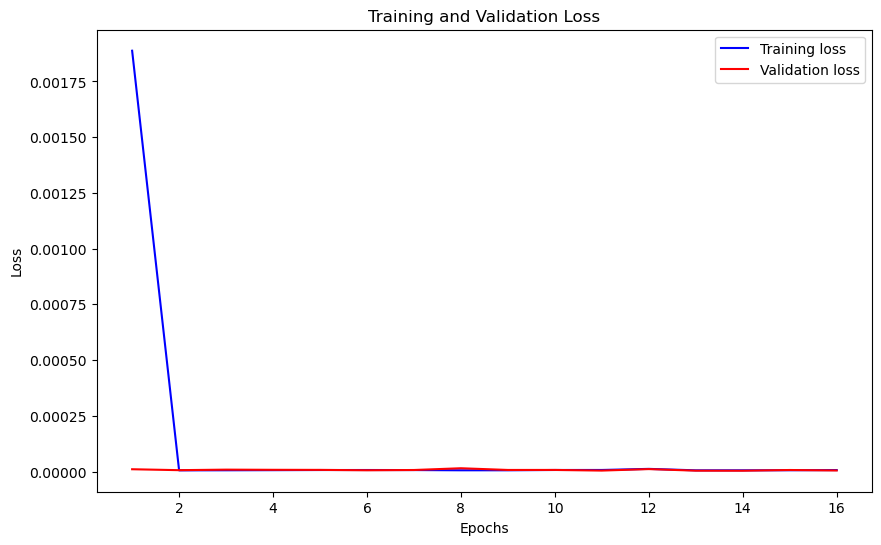

In [63]:
import matplotlib.pyplot as plt

historyi = histories[0]
# Assuming 'history' is the history object returned from the 'fit()' method
# Extract loss and validation loss
loss = historyi.history['loss']
val_loss = historyi.history.get('val_loss')  # 'None' if no validation loss

# Create count of the number of epochs
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss')  # 'bo' for blue dot
plt.plot(epochs, val_loss, 'r', label='Validation loss') if val_loss is not None else None
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
